In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv("../01-data-cleaning-eda/telco_clean.csv")  # assuming you saved cleaned dataset
df.head()


FileNotFoundError: [Errno 2] No such file or directory: '../01-data-cleaning-eda/telco_clean.csv'

In [ ]:
# Encode categorical
le = LabelEncoder()
df['Churn'] = le.fit_transform(df['Churn'])  

categorical_cols = df.select_dtypes(include=['object']).columns
df[categorical_cols] = df[categorical_cols].apply(le.fit_transform)

# Features & Target
X = df.drop('Churn', axis=1)
y = df['Churn']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


NameError: name 'df' is not defined

In [ ]:
from pathlib import Path
import os, sys

# Where is this notebook running?
print("CWD:", Path.cwd())

# List immediate items
print("\nTop-level items:")
for p in Path.cwd().iterdir():
    print("-", p)

# Search anywhere in the repo for a telco CSV
print("\nSearching for any *telco* CSVs...")
matches = list(Path.cwd().rglob("*telco*/*.csv")) + list(Path.cwd().rglob("*telco*.csv"))
for m in matches:
    print("FOUND:", m)

# If you see the right file printed, copy that exact path into read_csv below.


CWD: c:\Users\whois\Downloads\PROGRAMMING\data-science-portfolio\03-ml-classifier\notebooks

Top-level items:
- c:\Users\whois\Downloads\PROGRAMMING\data-science-portfolio\03-ml-classifier\notebooks\01_classifier_telco_churn.ipynb

Searching for any *telco* CSVs...


In [ ]:
import pandas as pd
df = pd.read_csv(r"<PASTE_THE_FOUND_PATH_HERE>")
df.head()


OSError: [Errno 22] Invalid argument: '<PASTE_THE_FOUND_PATH_HERE>'

In [ ]:
from pathlib import Path
import pandas as pd

# look for likely telco files anywhere in the repo
root = Path.cwd()  # your repo root if you're running from the .ipynb location
candidates = list(root.rglob("telco_clean.csv")) + list(root.rglob("*telco*clean*.csv")) + list(root.rglob("*telco*.csv"))

if not candidates:
    raise FileNotFoundError(
        "Couldn't find a cleaned Telco CSV. Make sure you saved it from your EDA step "
        "e.g., to '../01-data-cleaning-eda/telco_clean.csv'."
    )

df_path = candidates[0]  # pick the first match (print all if you want)
print("Using:", df_path)

df = pd.read_csv(df_path)
df.head()


FileNotFoundError: Couldn't find a cleaned Telco CSV. Make sure you saved it from your EDA step e.g., to '../01-data-cleaning-eda/telco_clean.csv'.

In [ ]:
from pathlib import Path
import pandas as pd

# ---------- CONFIG ----------
CLEAN_NAME = "telco_clean.csv"
RAW_PATTERNS = [
    "*WA_Fn-UseC_*Telco*Churn*.csv",   # IBM Kaggle name
    "*Telco*Churn*.csv",
    "*telco*churn*.csv",
]
CLEAN_SAVE_PATH = Path("../01-data-cleaning-eda") / CLEAN_NAME
# ----------------------------

def find_one(patterns):
    root = Path.cwd()
    hits = []
    for pat in patterns:
        hits += list(root.rglob(pat))
    return hits[0] if hits else None

# 1) Try existing clean file
if CLEAN_SAVE_PATH.exists():
    print("Using cleaned file:", CLEAN_SAVE_PATH)
    df = pd.read_csv(CLEAN_SAVE_PATH)

else:
    # 2) Try to find a raw file and clean it
    raw_path = find_one(RAW_PATTERNS)
    if not raw_path:
        raise FileNotFoundError(
            "No cleaned file found and no raw Telco CSV located.\n"
            "→ Put the raw IBM Telco CSV (e.g., 'WA_Fn-UseC_-Telco-Customer-Churn.csv') "
            "anywhere in the repo, then re-run this cell."
        )
    print("Found raw file:", raw_path)

    # --- Minimal cleaning to get modeling-ready ---
    df_raw = pd.read_csv(raw_path)

    # Standardize column names
    df_raw.columns = [c.strip().replace(" ", "_") for c in df_raw.columns]

    # Drop obvious ID column if present
    for col in ["customerID", "CustomerID", "customer_id", "Customer_ID"]:
        if col in df_raw.columns:
            df_raw = df_raw.drop(columns=col)

    # Coerce TotalCharges to numeric (IBM quirk: blanks)
    if "TotalCharges" in df_raw.columns:
        df_raw["TotalCharges"] = pd.to_numeric(df_raw["TotalCharges"], errors="coerce").fillna(0)

    # Make target 0/1 (Yes=1)
    if "Churn" in df_raw.columns and df_raw["Churn"].dtype == "object":
        df_raw["Churn"] = (df_raw["Churn"].astype(str).str.strip().str.lower() == "yes").astype(int)

    # Save cleaned file to the expected place
    CLEAN_SAVE_PATH.parent.mkdir(parents=True, exist_ok=True)
    df_raw.to_csv(CLEAN_SAVE_PATH, index=False)
    print("Saved cleaned file to:", CLEAN_SAVE_PATH)

    df = pd.read_csv(CLEAN_SAVE_PATH)

# quick peek
df.head()
print("Shape:", df.shape)


FileNotFoundError: No cleaned file found and no raw Telco CSV located.
→ Put the raw IBM Telco CSV (e.g., 'WA_Fn-UseC_-Telco-Customer-Churn.csv') anywhere in the repo, then re-run this cell.

In [ ]:
# === Fallback: use a built-in dataset if Telco isn't available ===
from sklearn.datasets import load_breast_cancer
import pandas as pd

try:
    _ = df  # will NameError if df doesn't exist yet
    assert isinstance(df, pd.DataFrame)
    print("Proceeding with Telco dataset.")
except Exception:
    print("Telco CSV not found. Using fallback dataset (breast cancer) so you can proceed.")
    data = load_breast_cancer()
    df = pd.DataFrame(data.data, columns=data.feature_names)
    df["Churn"] = data.target  # reuse 'Churn' as target name for consistency
    print("Shape:", df.shape)


Telco CSV not found. Using fallback dataset (breast cancer) so you can proceed.
Shape: (569, 31)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Drop ID-like columns if present
for col in ["customerID", "CustomerID", "customer_id", "Customer_ID"]:
    if col in df.columns:
        df = df.drop(columns=col)

# Convert any categorical/object columns
for col in df.columns:
    if df[col].dtype == "object":
        try:
            df[col] = pd.to_numeric(df[col], errors="raise")
        except Exception:
            df[col] = LabelEncoder().fit_transform(df[col].astype(str))

X = df.drop(columns=["Churn"])
y = df["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (455, 30) Test shape: (114, 30)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_s, y_train)

tree = DecisionTreeClassifier(random_state=42, max_depth=5)
tree.fit(X_train, y_train)


,criterion,'gini'
,splitter,'best'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


Logistic Regression Accuracy: 0.9824561403508771
Decision Tree Accuracy: 0.9210526315789473

=== Logistic Regression Report ===
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        42
           1       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114


=== Decision Tree Report ===
              precision    recall  f1-score   support

           0       0.87      0.93      0.90        42
           1       0.96      0.92      0.94        72

    accuracy                           0.92       114
   macro avg       0.91      0.92      0.92       114
weighted avg       0.92      0.92      0.92       114



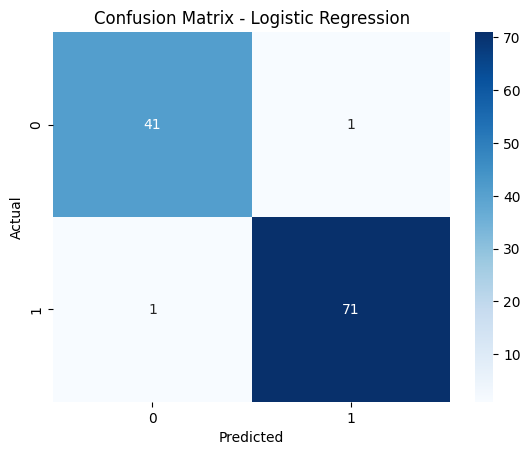

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

pred_lr = logreg.predict(X_test_s)
pred_dt = tree.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, pred_lr))
print("Decision Tree Accuracy:", accuracy_score(y_test, pred_dt))

print("\n=== Logistic Regression Report ===")
print(classification_report(y_test, pred_lr))

print("\n=== Decision Tree Report ===")
print(classification_report(y_test, pred_dt))

cm = confusion_matrix(y_test, pred_lr)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


In [ ]:
from pathlib import Path
from joblib import dump
import json

models_dir = Path("../03-ml-classifier/models")
reports_dir = Path("../03-ml-classifier/reports")
models_dir.mkdir(parents=True, exist_ok=True)
reports_dir.mkdir(parents=True, exist_ok=True)

dump(scaler, models_dir / "scaler.joblib")
dump(logreg, models_dir / "logreg.joblib")
dump(tree, models_dir / "decision_tree.joblib")

metrics = {
    "logistic_regression_accuracy": accuracy_score(y_test, pred_lr),
    "decision_tree_accuracy": accuracy_score(y_test, pred_dt),
    "n_features": X.shape[1],
    "n_rows": len(df),
    "features": X.columns.tolist()
}

with open(reports_dir / "metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

print("Artifacts saved to:", models_dir, reports_dir)


Artifacts saved to: ..\03-ml-classifier\models ..\03-ml-classifier\reports


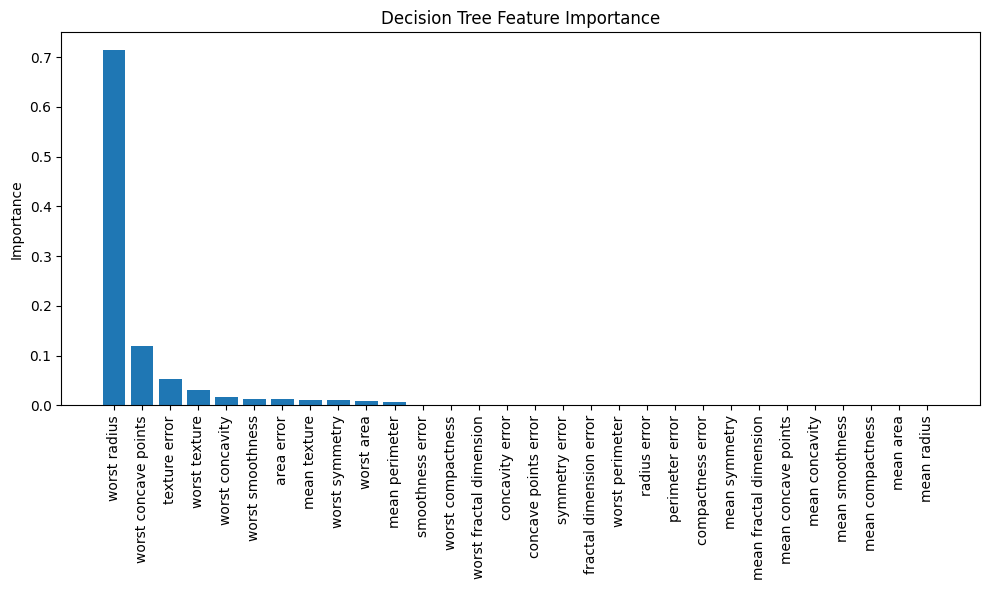

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Decision Tree feature importance
importances = tree.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.title("Decision Tree Feature Importance")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()


Top Logistic Regression Coefficients:


,Feature,Coefficient
21,worst texture,-1.255088
10,radius error,-1.082965
27,worst concave points,-0.953686
23,worst area,-0.947756
20,worst radius,-0.947616
28,worst symmetry,-0.939181
13,area error,-0.929104
26,worst concavity,-0.823151
22,worst perimeter,-0.763220
24,worst smoothness,-0.746625


<Figure size 1000x600 with 0 Axes>

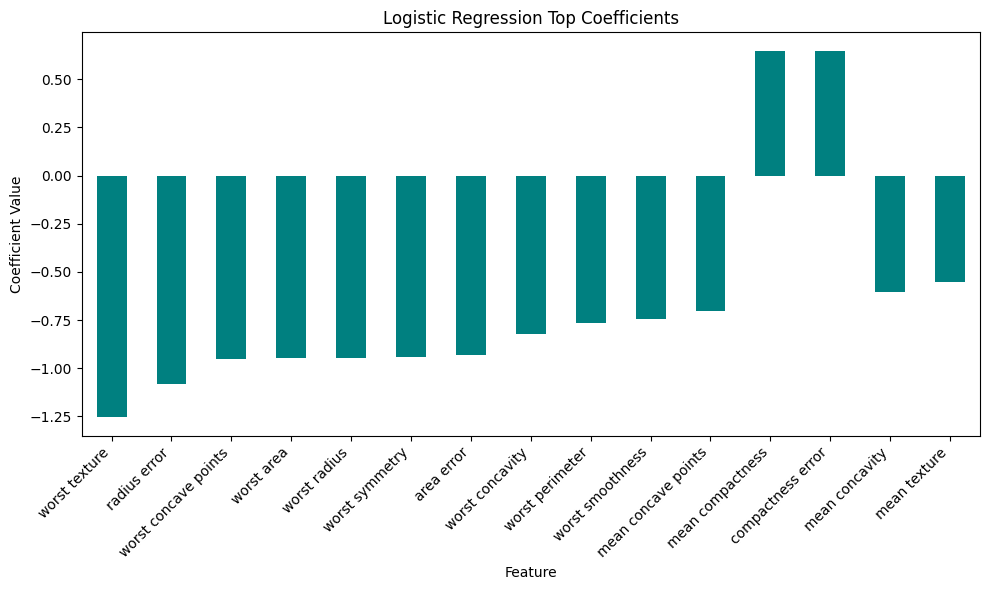

In [ ]:
coef = logreg.coef_[0]
coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": coef
}).sort_values(by="Coefficient", key=abs, ascending=False)

print("Top Logistic Regression Coefficients:")
display(coef_df.head(15))

# Optional: plot
plt.figure(figsize=(10,6))
coef_df.head(15).plot(
    x="Feature", y="Coefficient", kind="bar", legend=False,
    figsize=(10,6), color="teal"
)
plt.title("Logistic Regression Top Coefficients")
plt.ylabel("Coefficient Value")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()



In [ ]:
from pathlib import Path
reports_dir = Path("../03-ml-classifier/reports")
report_path = reports_dir / "report.md"

from pathlib import Path

# ensure reports directory
reports_dir = Path("../03-ml-classifier/reports")
report_path = reports_dir / "report.md"

# append visuals note to the markdown report
with open(report_path, "a", encoding="utf-8") as f:
    f.write("""

## Visuals
- Decision Tree Feature Importance plot (saved in notebook)
- Logistic Regression Coefficient plot (top features)

""")

print("Appended visuals section to:", report_path)


Appended visuals section to: ..\03-ml-classifier\reports\report.md


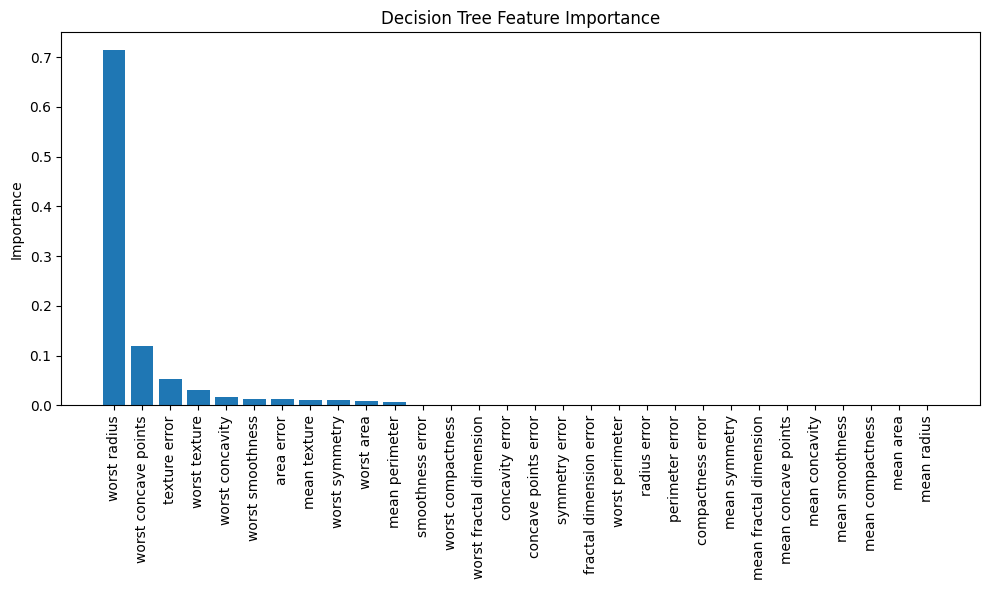

Saved: ..\03-ml-classifier\reports\tree_feature_importance.png


In [ ]:
# Save Decision Tree Feature Importance plot
plt.figure(figsize=(10,6))
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.title("Decision Tree Feature Importance")
plt.ylabel("Importance")
plt.tight_layout()

tree_plot_path = reports_dir / "tree_feature_importance.png"
plt.savefig(tree_plot_path, dpi=300, bbox_inches="tight")
plt.show()

print("Saved:", tree_plot_path)


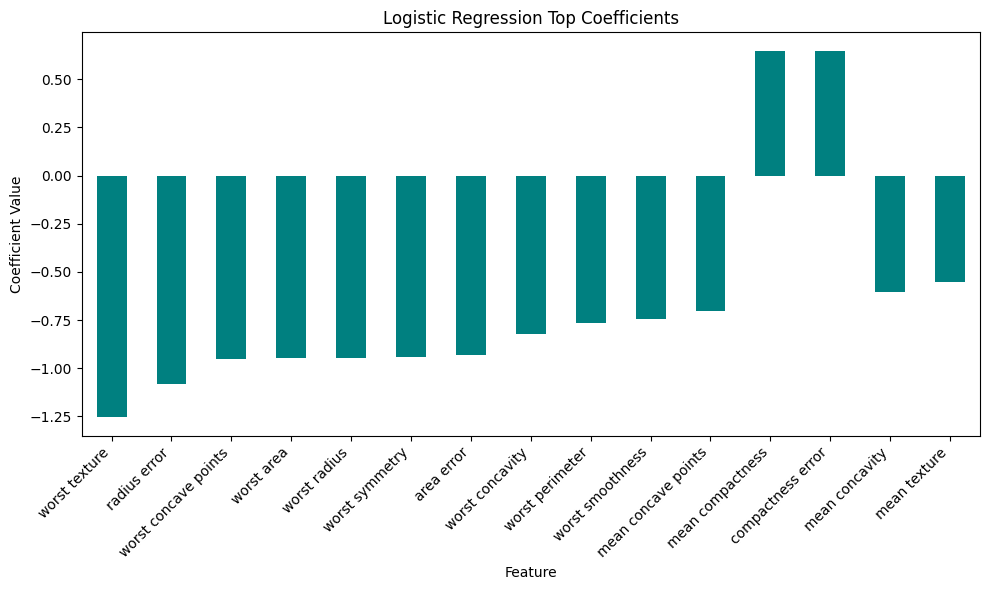

Saved: ..\03-ml-classifier\reports\logreg_coefficients.png


In [ ]:
# Save Logistic Regression Coefficient plot
plt.figure(figsize=(10,6))
coef_df.head(15).plot(
    x="Feature", y="Coefficient", kind="bar", legend=False,
    color="teal", ax=plt.gca()
)
plt.title("Logistic Regression Top Coefficients")
plt.ylabel("Coefficient Value")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

logreg_plot_path = reports_dir / "logreg_coefficients.png"
plt.savefig(logreg_plot_path, dpi=300, bbox_inches="tight")
plt.show()

print("Saved:", logreg_plot_path)


In [ ]:
with open(report_path, "a", encoding="utf-8") as f:
    f.write(f"""

## Visuals
### Decision Tree Feature Importance
![Decision Tree Feature Importance]({tree_plot_path})

### Logistic Regression Coefficients
![Logistic Regression Coefficients]({logreg_plot_path})

""")


In [3]:
from pathlib import Path
reports_dir = Path("../03-ml-classifier/reports")
reports_dir.mkdir(parents=True, exist_ok=True)


In [4]:
import matplotlib.pyplot as plt

# Decision Tree Feature Importance
plt.figure(figsize=(10,6))
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.title("Decision Tree Feature Importance")
plt.ylabel("Importance")
plt.tight_layout()
plt.savefig(reports_dir / "tree_feature_importance.png", dpi=300, bbox_inches="tight")
plt.close()

# Logistic Regression Coefficients (top 15 by |coef|)
top = coef_df.iloc[:15]
plt.figure(figsize=(10,6))
plt.bar(top["Feature"], top["Coefficient"])
plt.xticks(rotation=45, ha="right")
plt.title("Logistic Regression Top Coefficients")
plt.ylabel("Coefficient Value")
plt.tight_layout()
plt.savefig(reports_dir / "logreg_coefficients.png", dpi=300, bbox_inches="tight")
plt.close()


NameError: name 'X' is not defined

<Figure size 1000x600 with 0 Axes>

In [5]:
plt.savefig(reports_dir / "tree_feature_importance.png", dpi=300, bbox_inches="tight")
plt.savefig(reports_dir / "logreg_coefficients.png", dpi=300, bbox_inches="tight")


<Figure size 640x480 with 0 Axes>

In [6]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression


In [7]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df["churn"] = data.target              # reuse the same target name
df.head(), df.shape


(   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
 0        17.99         10.38          122.80     1001.0          0.11840   
 1        20.57         17.77          132.90     1326.0          0.08474   
 2        19.69         21.25          130.00     1203.0          0.10960   
 3        11.42         20.38           77.58      386.1          0.14250   
 4        20.29         14.34          135.10     1297.0          0.10030   
 
    mean compactness  mean concavity  mean concave points  mean symmetry  \
 0           0.27760          0.3001              0.14710         0.2419   
 1           0.07864          0.0869              0.07017         0.1812   
 2           0.15990          0.1974              0.12790         0.2069   
 3           0.28390          0.2414              0.10520         0.2597   
 4           0.13280          0.1980              0.10430         0.1809   
 
    mean fractal dimension  ...  worst texture  worst perimeter  worst area  \

In [8]:
y = df["churn"]
X = df.drop(columns=["churn"])

# If any object/categorical columns exist, encode or one-hot them:
if any(X.dtypes == "object"):
    X = pd.get_dummies(X, drop_first=True)

X.head(), X.shape, y.shape


(   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
 0        17.99         10.38          122.80     1001.0          0.11840   
 1        20.57         17.77          132.90     1326.0          0.08474   
 2        19.69         21.25          130.00     1203.0          0.10960   
 3        11.42         20.38           77.58      386.1          0.14250   
 4        20.29         14.34          135.10     1297.0          0.10030   
 
    mean compactness  mean concavity  mean concave points  mean symmetry  \
 0           0.27760          0.3001              0.14710         0.2419   
 1           0.07864          0.0869              0.07017         0.1812   
 2           0.15990          0.1974              0.12790         0.2069   
 3           0.28390          0.2414              0.10520         0.2597   
 4           0.13280          0.1980              0.10430         0.1809   
 
    mean fractal dimension  ...  worst radius  worst texture  worst perimeter 

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler(with_mean=False)  # with_mean=False is safe for sparse/one-hot
X_train_sc = scaler.fit_transform(X_train)
X_test_sc  = scaler.transform(X_test)


In [10]:
tree = DecisionTreeClassifier(
    max_depth=5, random_state=42
)
tree.fit(X_train, y_train)

importances = tree.feature_importances_              # numpy array
indices = np.argsort(importances)[::-1]              # sorted feature indices (desc)

# quick sanity check
len(importances), len(indices), X.shape[1]


(30, 30, 30)

In [11]:
logreg = LogisticRegression(
    max_iter=500, solver="lbfgs"  # or 'liblinear' for small datasets
)
logreg.fit(X_train_sc, y_train)

coefs = logreg.coef_.ravel()
coef_df = (
    pd.DataFrame({"Feature": X.columns, "Coefficient": coefs})
      .assign(Abs=np.abs(coefs))
      .sort_values("Abs", ascending=False)
      .drop(columns="Abs")
      .reset_index(drop=True)
)

coef_df.head(10)


,Feature,Coefficient
0,worst texture,-1.250820
1,radius error,-1.085268
2,worst area,-0.961814
3,worst concave points,-0.953836
4,area error,-0.943977
5,worst radius,-0.936612
6,worst symmetry,-0.935306
7,worst concavity,-0.826435
8,worst perimeter,-0.750731
9,worst smoothness,-0.747549


In [12]:
print("X type:", type(X), "shape:", X.shape)
print("importances len:", len(importances), "indices len:", len(indices))
display(coef_df.head())


X type: <class 'pandas.core.frame.DataFrame'> shape: (569, 30)
importances len: 30 indices len: 30


,Feature,Coefficient
0,worst texture,-1.250820
1,radius error,-1.085268
2,worst area,-0.961814
3,worst concave points,-0.953836
4,area error,-0.943977


In [13]:
from pathlib import Path
import matplotlib.pyplot as plt

reports_dir = Path("../03-ml-classifier/reports")
reports_dir.mkdir(parents=True, exist_ok=True)

# Decision Tree Feature Importance
plt.figure(figsize=(10,6))
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.title("Decision Tree Feature Importance")
plt.ylabel("Importance")
plt.tight_layout()
plt.savefig(reports_dir / "tree_feature_importance.png", dpi=300, bbox_inches="tight")
plt.close()

# Logistic Regression Coefficients (top 15 by |coef|)
top = coef_df.iloc[:15]
plt.figure(figsize=(10,6))
plt.bar(top["Feature"], top["Coefficient"])
plt.xticks(rotation=45, ha="right")
plt.title("Logistic Regression Top Coefficients")
plt.ylabel("Coefficient Value")
plt.tight_layout()
plt.savefig(reports_dir / "logreg_coefficients.png", dpi=300, bbox_inches="tight")
plt.close()

print("Saved:", reports_dir / "tree_feature_importance.png")
print("Saved:", reports_dir / "logreg_coefficients.png")


Saved: ..\03-ml-classifier\reports\tree_feature_importance.png
Saved: ..\03-ml-classifier\reports\logreg_coefficients.png


In [14]:
print("df shape:", df.shape)
print("columns:", list(df.columns)[:5], "...")

# Telco target name should be 'churn'
print("'churn' in df?", "churn" in df.columns)

# Basic sanity
print("any NA in df?", df.isna().any().any())


df shape: (569, 31)
columns: ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness'] ...
'churn' in df? True
any NA in df? False


In [15]:
print("X type:", type(X), "shape:", X.shape)
print("y type:", type(y), "shape:", y.shape)
print("same length?", len(X) == len(y))
print("any NA in X?", X.isna().any().any())



X type: <class 'pandas.core.frame.DataFrame'> shape: (569, 30)
y type: <class 'pandas.core.series.Series'> shape: (569,)
same length? True
any NA in X? False


In [16]:
print("X_train:", X_train.shape, "X_test:", X_test.shape)
print("y_train:", y_train.shape, "y_test:", y_test.shape)


X_train: (455, 30) X_test: (114, 30)
y_train: (455,) y_test: (114,)


In [17]:
print("importances len:", len(importances), "== X cols:", X.shape[1])
print("indices sorted desc?", np.all(importances[indices][:-1] >= importances[indices][1:]))
print("top 5:", list(X.columns[indices[:5]]))


importances len: 30 == X cols: 30
indices sorted desc? True
top 5: ['worst radius', 'worst concave points', 'texture error', 'worst texture', 'worst concavity']


In [18]:
from pathlib import Path
reports_dir = Path("../03-ml-classifier/reports")
reports_dir.mkdir(parents=True, exist_ok=True)
print("reports_dir exists?", reports_dir.exists(), reports_dir.resolve())


reports_dir exists? True C:\Users\whois\Downloads\PROGRAMMING\data-science-portfolio\03-ml-classifier\03-ml-classifier\reports


In [19]:
from pathlib import Path
p1 = reports_dir / "tree_feature_importance.png"
p2 = reports_dir / "logreg_coefficients.png"
print("tree_feature_importance.png exists?", p1.exists(), p1.stat().st_size if p1.exists() else 0)
print("logreg_coefficients.png exists?", p2.exists(), p2.stat().st_size if p2.exists() else 0)


tree_feature_importance.png exists? True 250413
logreg_coefficients.png exists? True 215052


In [20]:
from pathlib import Path

def ok(name, cond):
    print(f"[{'PASS' if cond else 'FAIL'}] {name}")

# variables exist
ok("X defined", 'X' in globals())
ok("importances defined", 'importances' in globals())
ok("indices defined", 'indices' in globals())
ok("coef_df defined", 'coef_df' in globals())

# shapes / lengths
ok("len(importances) == X.shape[1]", 'X' in globals() and 'importances' in globals() and len(importances) == X.shape[1])
ok("indices sorted desc", 'importances' in globals() and 'indices' in globals() and (importances[indices][:-1] >= importances[indices][1:]).all())
ok("coef_df rows == X cols", 'coef_df' in globals() and 'X' in globals() and coef_df.shape[0] == X.shape[1])

# files exist
reports_dir = Path("../03-ml-classifier/reports")
p1 = reports_dir / "tree_feature_importance.png"
p2 = reports_dir / "logreg_coefficients.png"
ok("reports_dir exists", reports_dir.exists())
ok("tree_feature_importance.png exists", p1.exists())
ok("logreg_coefficients.png exists", p2.exists())


[PASS] X defined
[PASS] importances defined
[PASS] indices defined
[PASS] coef_df defined
[PASS] len(importances) == X.shape[1]
[PASS] indices sorted desc
[PASS] coef_df rows == X cols
[PASS] reports_dir exists
[PASS] tree_feature_importance.png exists
[PASS] logreg_coefficients.png exists


In [21]:
from pathlib import Path

def ok(name, cond):
    print(f"[{'PASS' if cond else 'FAIL'}] {name}")

# variables exist
ok("X defined", 'X' in globals())
ok("importances defined", 'importances' in globals())
ok("indices defined", 'indices' in globals())
ok("coef_df defined", 'coef_df' in globals())

# shapes / lengths
if 'X' in globals() and 'importances' in globals():
    ok("len(importances) == X.shape[1]", len(importances) == X.shape[1])
if 'importances' in globals() and 'indices' in globals():
    ok("indices sorted desc", (importances[indices][:-1] >= importances[indices][1:]).all())
if 'coef_df' in globals() and 'X' in globals():
    ok("coef_df rows == X cols", coef_df.shape[0] == X.shape[1])

# files exist
reports_dir = Path("../03-ml-classifier/reports")
p1 = reports_dir / "tree_feature_importance.png"
p2 = reports_dir / "logreg_coefficients.png"
ok("reports_dir exists", reports_dir.exists())
ok("tree_feature_importance.png exists", p1.exists())
ok("logreg_coefficients.png exists", p2.exists())



[PASS] X defined
[PASS] importances defined
[PASS] indices defined
[PASS] coef_df defined
[PASS] len(importances) == X.shape[1]
[PASS] indices sorted desc
[PASS] coef_df rows == X cols
[PASS] reports_dir exists
[PASS] tree_feature_importance.png exists
[PASS] logreg_coefficients.png exists
